In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 102440
New cases registered today: 3803
New cases registered today in %: 3.86
Doubling time in the last five days: 12.7
Doubling time yesterday: 11.1
Trend of new cases (in %) in the last 5 days: 31.5


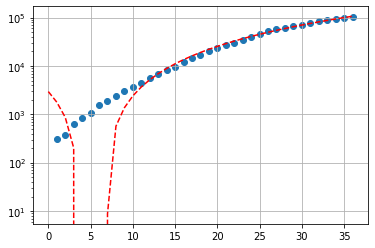

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1401
New cases registered today: 56
New cases registered today in %: 4.16
Doubling time in the last five days: 8.8
Doubling time yesterday: 6.9
Trend of new cases (in %) in the last 5 days: 48.1


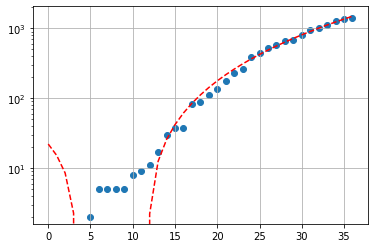

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.7195
Total cases up to today: 280
New cases registered today: 7
New cases registered today in %: 2.56
Doubling time in the last five days: 7.4
Doubling time yesterday: 5.5
Trend of new cases (in %) in the last 5 days: 60.0


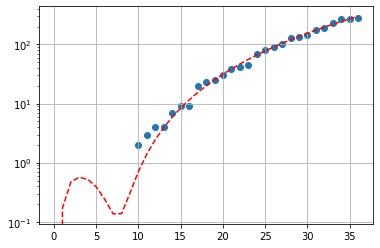

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.4074
Total cases up to today: 123
New cases registered today: 8
New cases registered today in %: 6.96
Doubling time in the last five days: 5.3
Doubling time yesterday: 5.3
Trend of new cases (in %) in the last 5 days: 92.19


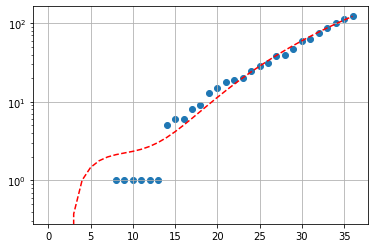

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 1.9358
Total cases up to today: 622
New cases registered today: 28
New cases registered today in %: 4.71
Doubling time in the last five days: 10.3
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 39.78


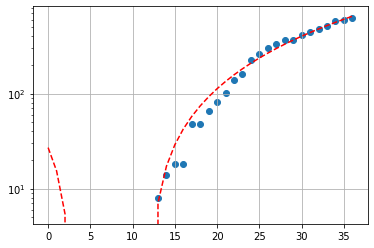

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.2135
Total cases up to today: 376
New cases registered today: 13
New cases registered today in %: 3.58
Doubling time in the last five days: 9.6
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 43.51


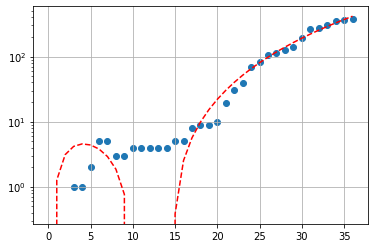

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 226
New cases registered today: 12
New cases registered today in %: 5.61
Doubling time in the last five days: 6.6
Doubling time yesterday: 4.9
Trend of new cases (in %) in the last 5 days: 68.66


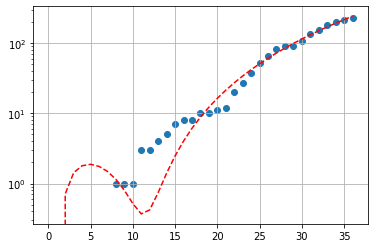

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.5208
Total cases up to today: 104
New cases registered today: 12
New cases registered today in %: 13.04
Doubling time in the last five days: 4.5
Doubling time yesterday: 3.7
Trend of new cases (in %) in the last 5 days: 116.67


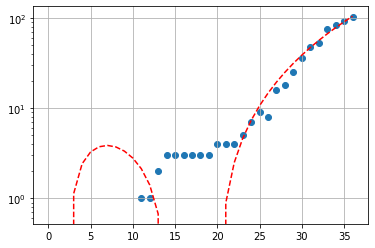

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.3291
Total cases up to today: 122
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 9.9
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 41.86


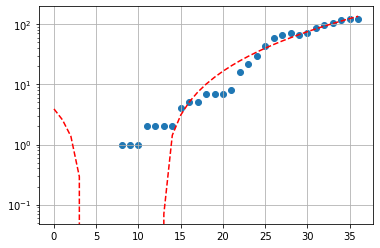

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1371
New cases registered today: 46
New cases registered today in %: 3.47
Doubling time in the last five days: 8.4
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 51.32


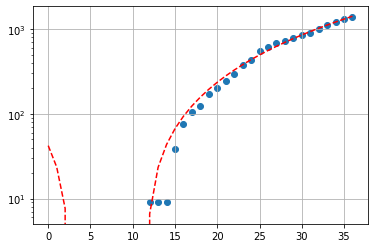

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 657
New cases registered today: 12
New cases registered today in %: 1.86
Doubling time in the last five days: 6.7
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 68.03


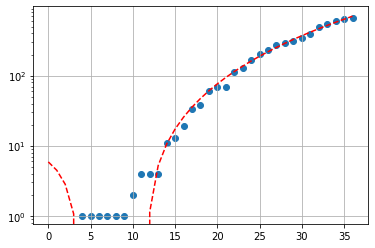

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.3836
Total cases up to today: 139
New cases registered today: 5
New cases registered today in %: 3.73
Doubling time in the last five days: 3.6
Doubling time yesterday: 3.6
Trend of new cases (in %) in the last 5 days: 162.26


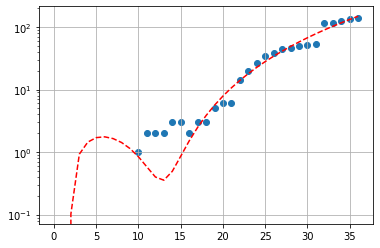

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.2613
Total cases up to today: 186
New cases registered today: 2
New cases registered today in %: 1.09
Doubling time in the last five days: 6.3
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 73.83


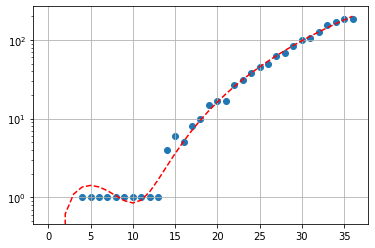

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.5297
Total cases up to today: 93
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 23.0
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 16.25


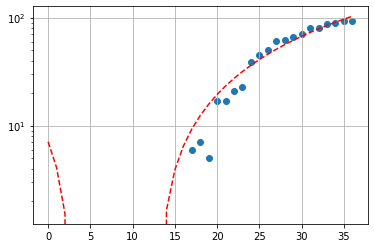

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.3521
Total cases up to today: 195
New cases registered today: 5
New cases registered today in %: 2.63
Doubling time in the last five days: 7.5
Doubling time yesterday: 5.8
Trend of new cases (in %) in the last 5 days: 58.54


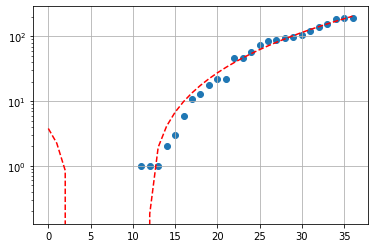

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.2722
Total cases up to today: 44
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 7.7
Doubling time yesterday: 5.3
Trend of new cases (in %) in the last 5 days: 57.14


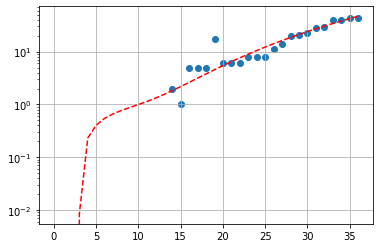

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 1917
New cases registered today: 92
New cases registered today in %: 5.04
Doubling time in the last five days: 8.6
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 49.77


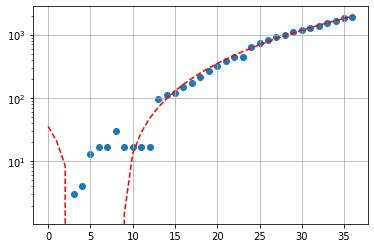

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.5336
Total cases up to today: 226
New cases registered today: 6
New cases registered today in %: 2.73
Doubling time in the last five days: 15.2
Doubling time yesterday: 14.1
Trend of new cases (in %) in the last 5 days: 25.56


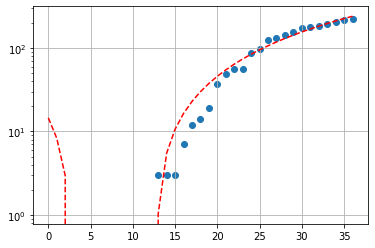

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.2717
Total cases up to today: 76
New cases registered today: 6
New cases registered today in %: 8.57
Doubling time in the last five days: 2.0
Doubling time yesterday: 2.2
Trend of new cases (in %) in the last 5 days: 442.86


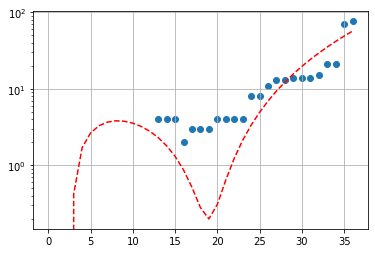

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.2391
Total cases up to today: 221
New cases registered today: 15
New cases registered today in %: 7.28
Doubling time in the last five days: 15.6
Doubling time yesterday: 15.6
Trend of new cases (in %) in the last 5 days: 24.86


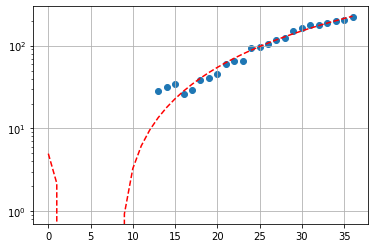

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.3389
Total cases up to today: 1053
New cases registered today: 62
New cases registered today in %: 6.26
Doubling time in the last five days: 7.5
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 58.35


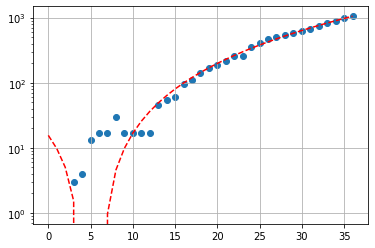

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.3087
Total cases up to today: 341
New cases registered today: 3
New cases registered today in %: 0.89
Doubling time in the last five days: 10.4
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 39.75


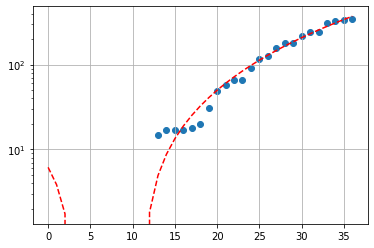

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


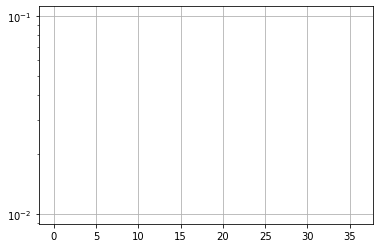

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 1.9223
Total cases up to today: 1940
New cases registered today: 68
New cases registered today in %: 3.63
Doubling time in the last five days: 7.9
Doubling time yesterday: 6.6
Trend of new cases (in %) in the last 5 days: 54.83


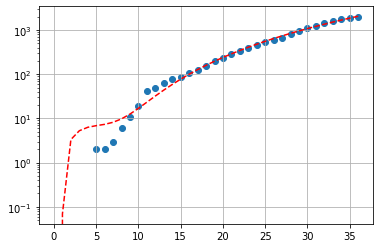

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 0.9186
Total cases up to today: 320
New cases registered today: 14
New cases registered today in %: 4.58
Doubling time in the last five days: 8.4
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 50.94


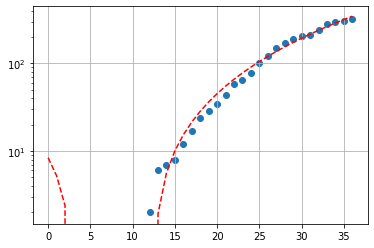

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 3.1704
Total cases up to today: 2222
New cases registered today: 85
New cases registered today in %: 3.98
Doubling time in the last five days: 12.3
Doubling time yesterday: 10.4
Trend of new cases (in %) in the last 5 days: 32.58


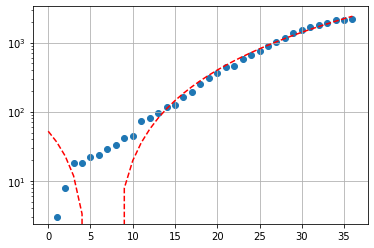

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 4.3061
Total cases up to today: 1933
New cases registered today: 74
New cases registered today in %: 3.98
Doubling time in the last five days: 19.0
Doubling time yesterday: 17.5
Trend of new cases (in %) in the last 5 days: 19.99


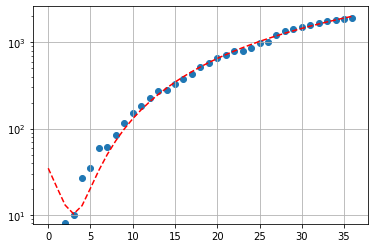

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 9.1889
Total cases up to today: 2635
New cases registered today: 119
New cases registered today in %: 4.73
Doubling time in the last five days: 19.9
Doubling time yesterday: 20.3
Trend of new cases (in %) in the last 5 days: 19.07


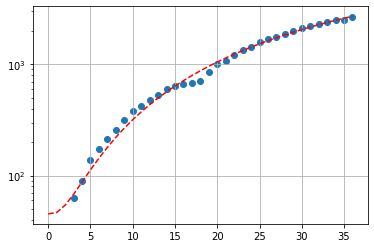

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.4818
Total cases up to today: 580
New cases registered today: 12
New cases registered today in %: 2.11
Doubling time in the last five days: 13.8
Doubling time yesterday: 9.0
Trend of new cases (in %) in the last 5 days: 28.6


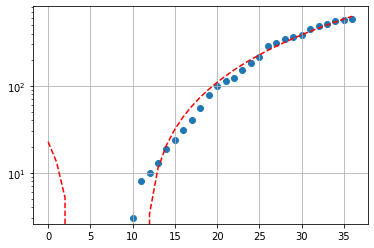

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 4.3325
Total cases up to today: 2307
New cases registered today: 99
New cases registered today in %: 4.48
Doubling time in the last five days: 11.3
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 35.87


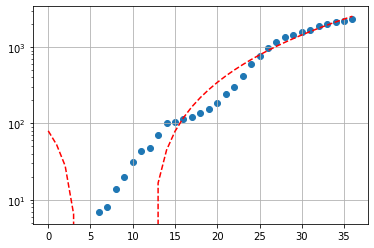

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.1777
Total cases up to today: 1407
New cases registered today: 25
New cases registered today in %: 1.81
Doubling time in the last five days: 20.6
Doubling time yesterday: 17.7
Trend of new cases (in %) in the last 5 days: 18.33


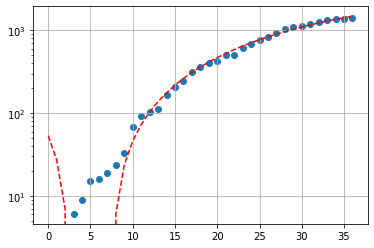

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 1584
New cases registered today: 92
New cases registered today in %: 6.17
Doubling time in the last five days: 13.1
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 30.37


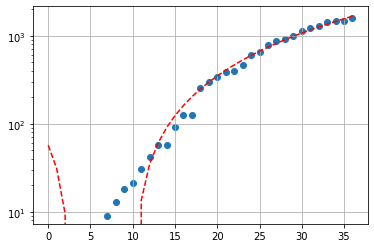

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.7016
Total cases up to today: 98
New cases registered today: 7
New cases registered today in %: 7.69
Doubling time in the last five days: 13.0
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 30.67


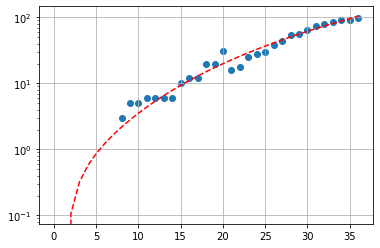

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.2979
Total cases up to today: 405
New cases registered today: 22
New cases registered today in %: 5.74
Doubling time in the last five days: 10.9
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 37.29


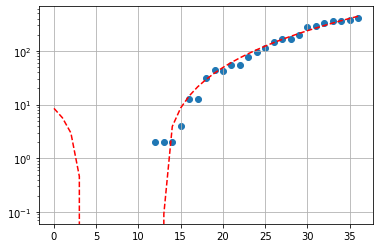

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 2.3223
Total cases up to today: 545
New cases registered today: 51
New cases registered today in %: 10.32
Doubling time in the last five days: 10.0
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 41.56


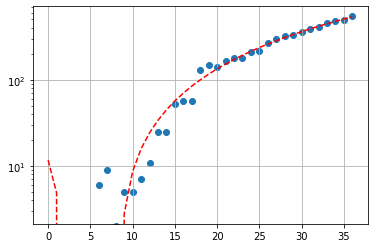

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.0085
Total cases up to today: 536
New cases registered today: 12
New cases registered today in %: 2.29
Doubling time in the last five days: 22.7
Doubling time yesterday: 17.7
Trend of new cases (in %) in the last 5 days: 16.52


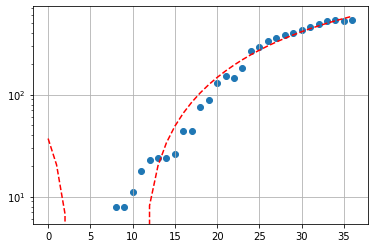

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 3077
New cases registered today: 179
New cases registered today in %: 6.18
Doubling time in the last five days: 9.0
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 47.08


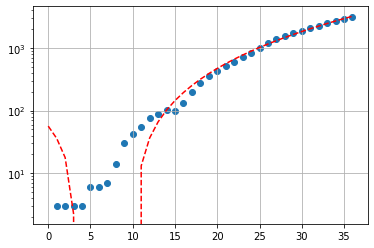

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.651
Total cases up to today: 321
New cases registered today: 31
New cases registered today in %: 10.69
Doubling time in the last five days: 4.8
Doubling time yesterday: 3.4
Trend of new cases (in %) in the last 5 days: 105.77


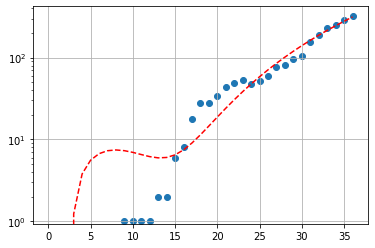

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.447
Total cases up to today: 257
New cases registered today: 3
New cases registered today in %: 1.18
Doubling time in the last five days: 15.7
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 24.76


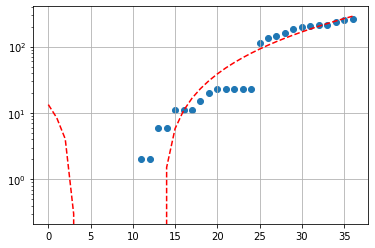

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 0.8385
Total cases up to today: 132
New cases registered today: 27
New cases registered today in %: 25.71
Doubling time in the last five days: 3.0
Doubling time yesterday: 3.5
Trend of new cases (in %) in the last 5 days: 221.95


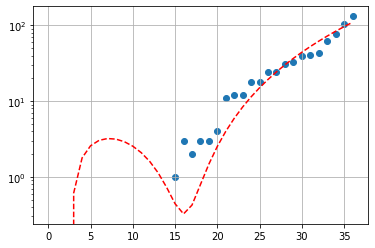

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.5021
Total cases up to today: 2186
New cases registered today: 118
New cases registered today in %: 5.71
Doubling time in the last five days: 10.4
Doubling time yesterday: 9.4
Trend of new cases (in %) in the last 5 days: 39.5


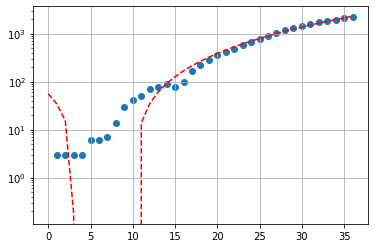

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.5674
Total cases up to today: 181
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 8.8
Doubling time yesterday: 8.8
Trend of new cases (in %) in the last 5 days: 48.36


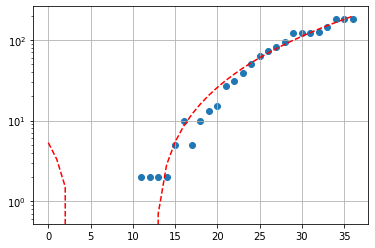

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 1826
New cases registered today: 31
New cases registered today in %: 1.73
Doubling time in the last five days: 11.0
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 37.19


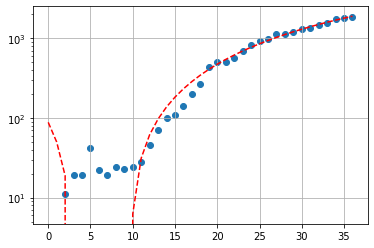

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 1.2881
Total cases up to today: 1095
New cases registered today: 26
New cases registered today in %: 2.43
Doubling time in the last five days: 9.6
Doubling time yesterday: 11.1
Trend of new cases (in %) in the last 5 days: 43.7


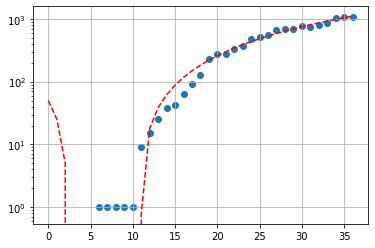

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 1.0877
Total cases up to today: 234
New cases registered today: -9
New cases registered today in %: -3.7
Doubling time in the last five days: 33.5
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 10.9


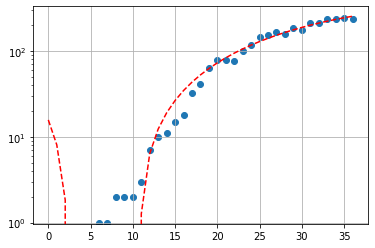

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 1.1237
Total cases up to today: 248
New cases registered today: 14
New cases registered today in %: 5.98
Doubling time in the last five days: 6.8
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 66.44


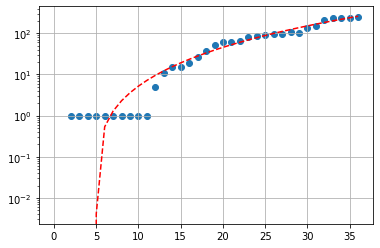

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 0.8912
Total cases up to today: 249
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 19.8
Doubling time yesterday: 20.3
Trend of new cases (in %) in the last 5 days: 19.14


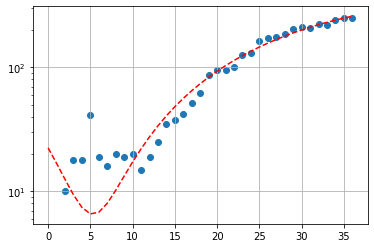

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 42283
New cases registered today: 1030
New cases registered today in %: 2.5
Doubling time in the last five days: 16.1
Doubling time yesterday: 13.1
Trend of new cases (in %) in the last 5 days: 24.06


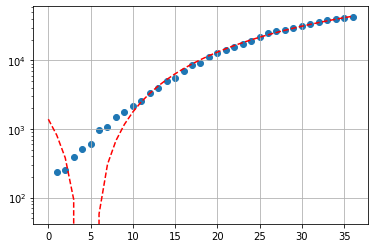

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 7.9311
Total cases up to today: 8803
New cases registered today: 139
New cases registered today in %: 1.6
Doubling time in the last five days: 20.9
Doubling time yesterday: 17.1
Trend of new cases (in %) in the last 5 days: 18.03


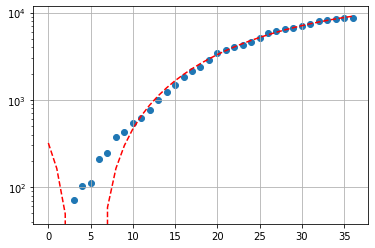

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 6.6283
Total cases up to today: 8367
New cases registered today: 154
New cases registered today in %: 1.88
Doubling time in the last five days: 18.4
Doubling time yesterday: 15.8
Trend of new cases (in %) in the last 5 days: 20.72


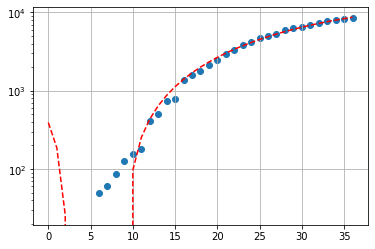

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 1.8344
Total cases up to today: 1101
New cases registered today: 40
New cases registered today in %: 3.77
Doubling time in the last five days: 9.4
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 44.49


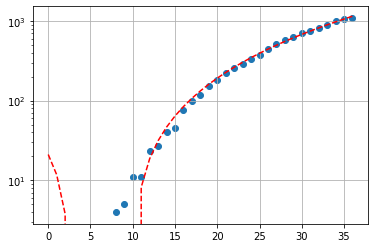

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 10.7655
Total cases up to today: 3869
New cases registered today: 81
New cases registered today in %: 2.14
Doubling time in the last five days: 25.1
Doubling time yesterday: 19.0
Trend of new cases (in %) in the last 5 days: 14.81


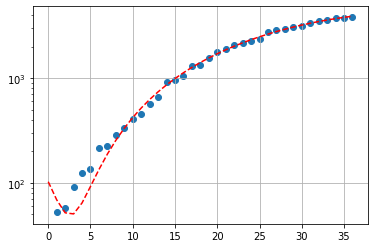

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 4.3332
Total cases up to today: 1470
New cases registered today: 33
New cases registered today in %: 2.3
Doubling time in the last five days: 14.6
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 26.83


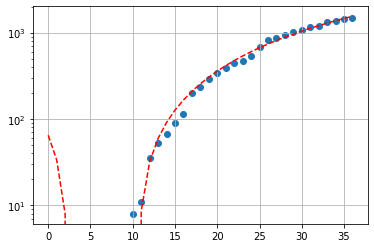

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 9.2266
Total cases up to today: 2116
New cases registered today: 29
New cases registered today in %: 1.39
Doubling time in the last five days: 47.8
Doubling time yesterday: 33.9
Trend of new cases (in %) in the last 5 days: 7.52


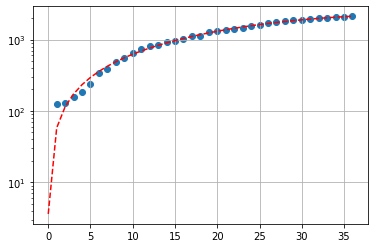

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 4.091
Total cases up to today: 1688
New cases registered today: 71
New cases registered today in %: 4.39
Doubling time in the last five days: 11.5
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 35.04


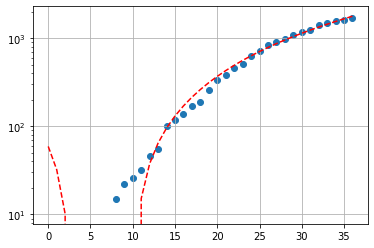

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 2.7689
Total cases up to today: 8911
New cases registered today: 235
New cases registered today in %: 2.71
Doubling time in the last five days: 13.7
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 28.73


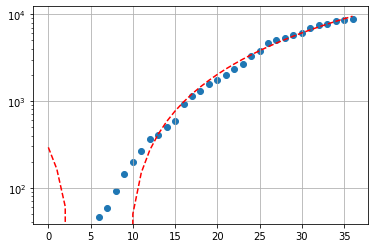

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 2.8336
Total cases up to today: 2462
New cases registered today: 100
New cases registered today in %: 4.23
Doubling time in the last five days: 10.2
Doubling time yesterday: 8.7
Trend of new cases (in %) in the last 5 days: 40.69


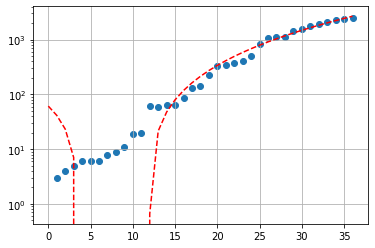

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 3.8977
Total cases up to today: 2133
New cases registered today: 97
New cases registered today in %: 4.76
Doubling time in the last five days: 14.7
Doubling time yesterday: 13.6
Trend of new cases (in %) in the last 5 days: 26.59


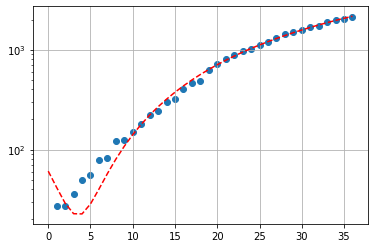

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 2.5904
Total cases up to today: 470
New cases registered today: 24
New cases registered today in %: 5.38
Doubling time in the last five days: 9.4
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 44.62


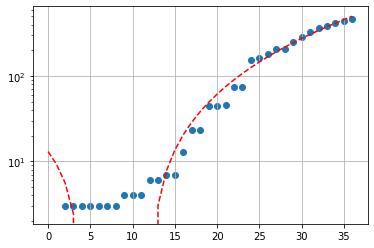

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 1.0033
Total cases up to today: 893
New cases registered today: 27
New cases registered today in %: 3.12
Doubling time in the last five days: 6.0
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 77.89


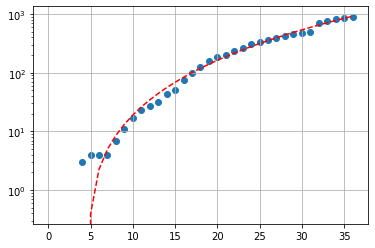

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 3754
New cases registered today: 135
New cases registered today in %: 3.73
Doubling time in the last five days: 17.0
Doubling time yesterday: 15.3
Trend of new cases (in %) in the last 5 days: 22.56


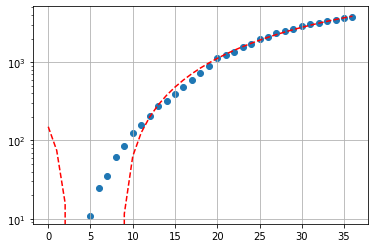

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 2.3538
Total cases up to today: 1116
New cases registered today: 56
New cases registered today in %: 5.28
Doubling time in the last five days: 13.9
Doubling time yesterday: 13.5
Trend of new cases (in %) in the last 5 days: 28.42


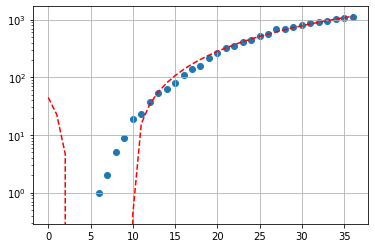

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.0599
Total cases up to today: 222
New cases registered today: 25
New cases registered today in %: 12.69
Doubling time in the last five days: 5.0
Doubling time yesterday: 3.8
Trend of new cases (in %) in the last 5 days: 100.0


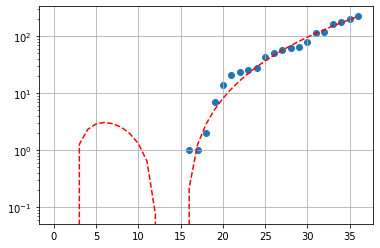

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.4813
Total cases up to today: 259
New cases registered today: 13
New cases registered today in %: 5.28
Doubling time in the last five days: 14.5
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 26.96


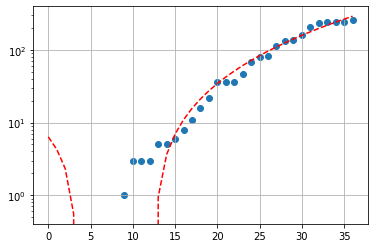

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.5458
Total cases up to today: 493
New cases registered today: 16
New cases registered today in %: 3.35
Doubling time in the last five days: 17.6
Doubling time yesterday: 18.4
Trend of new cases (in %) in the last 5 days: 21.73


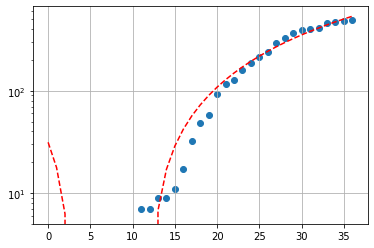

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 4.6131
Total cases up to today: 1664
New cases registered today: 25
New cases registered today in %: 1.53
Doubling time in the last five days: 28.6
Doubling time yesterday: 25.7
Trend of new cases (in %) in the last 5 days: 12.89


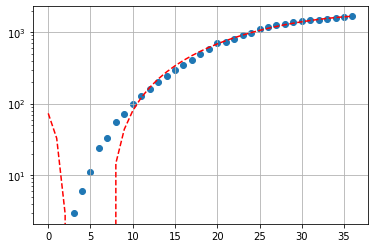

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 133
New cases registered today: 10
New cases registered today in %: 8.13
Doubling time in the last five days: 10.0
Doubling time yesterday: 5.3
Trend of new cases (in %) in the last 5 days: 41.49


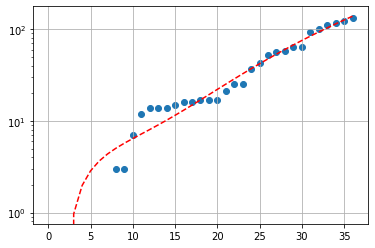

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.552
Total cases up to today: 124
New cases registered today: 10
New cases registered today in %: 8.77
Doubling time in the last five days: 9.2
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 45.88


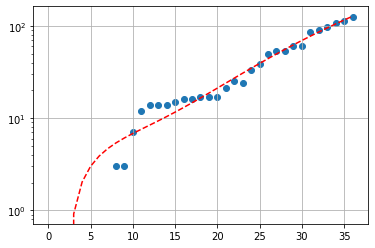

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.1049
Total cases up to today: 9
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: nan
Doubling time yesterday: 4.3
Trend of new cases (in %) in the last 5 days: 0.0


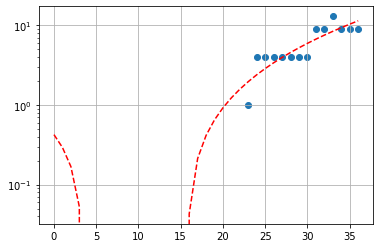

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 9090
New cases registered today: 579
New cases registered today in %: 6.8
Doubling time in the last five days: 9.7
Doubling time yesterday: 9.3
Trend of new cases (in %) in the last 5 days: 42.9


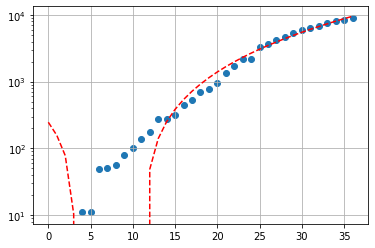

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 3.0868
Total cases up to today: 1317
New cases registered today: 37
New cases registered today in %: 2.89
Doubling time in the last five days: 11.7
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 34.39


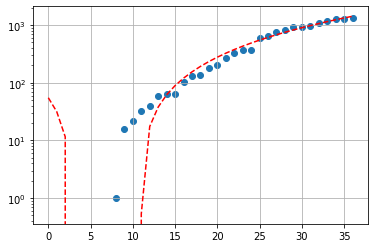

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 2.003
Total cases up to today: 434
New cases registered today: 32
New cases registered today in %: 7.96
Doubling time in the last five days: 8.0
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 53.9


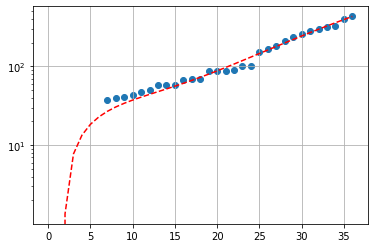

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 2.7443
Total cases up to today: 490
New cases registered today: 19
New cases registered today in %: 4.03
Doubling time in the last five days: 9.2
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 45.83


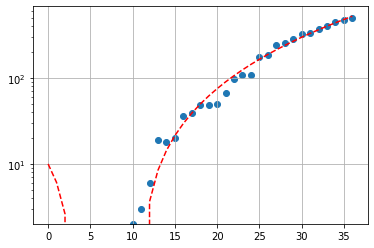

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 1.2409
Total cases up to today: 731
New cases registered today: 81
New cases registered today in %: 12.46
Doubling time in the last five days: 8.5
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 50.1


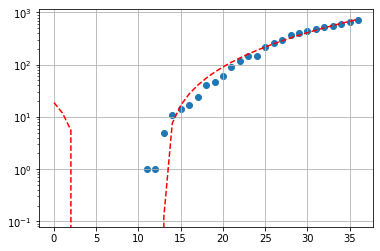

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 2.1532
Total cases up to today: 797
New cases registered today: 64
New cases registered today in %: 8.73
Doubling time in the last five days: 10.7
Doubling time yesterday: 9.9
Trend of new cases (in %) in the last 5 days: 38.13


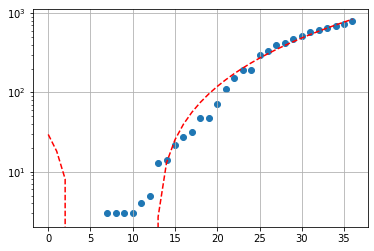

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 1.9558
Total cases up to today: 4455
New cases registered today: 305
New cases registered today in %: 7.35
Doubling time in the last five days: 9.6
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 43.34


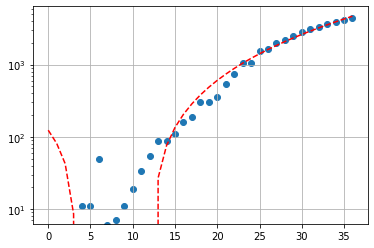

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 2.4614
Total cases up to today: 393
New cases registered today: 17
New cases registered today in %: 4.52
Doubling time in the last five days: 8.0
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 54.12


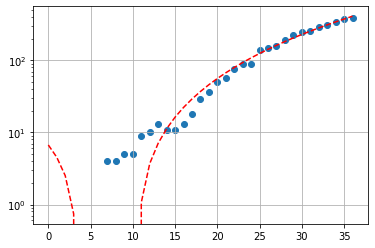

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 2.7205
Total cases up to today: 473
New cases registered today: 24
New cases registered today in %: 5.35
Doubling time in the last five days: 10.1
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 40.77


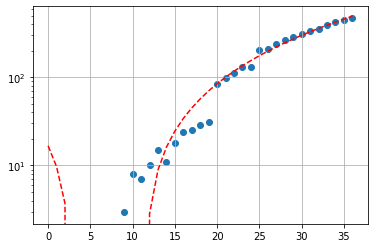

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 1777
New cases registered today: 97
New cases registered today in %: 5.77
Doubling time in the last five days: 8.0
Doubling time yesterday: 6.9
Trend of new cases (in %) in the last 5 days: 54.52


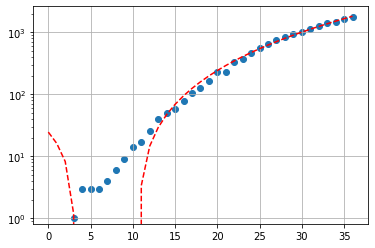

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.4888
Total cases up to today: 616
New cases registered today: 22
New cases registered today in %: 3.7
Doubling time in the last five days: 7.5
Doubling time yesterday: 6.1
Trend of new cases (in %) in the last 5 days: 59.17


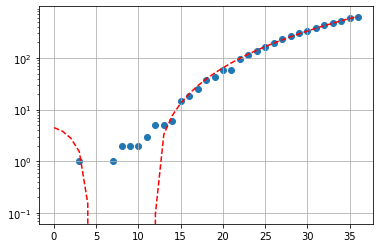

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.2828
Total cases up to today: 111
New cases registered today: 8
New cases registered today in %: 7.77
Doubling time in the last five days: 13.0
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 30.59


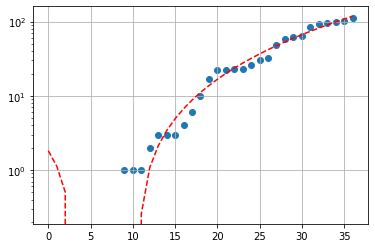

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.413
Total cases up to today: 164
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 11.7
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 34.43


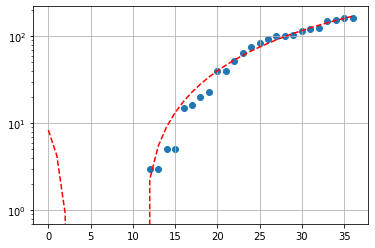

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.7271
Total cases up to today: 457
New cases registered today: 52
New cases registered today in %: 12.84
Doubling time in the last five days: 8.6
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 49.84


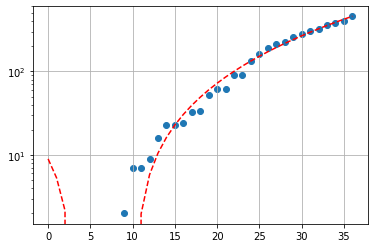

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.3778
Total cases up to today: 303
New cases registered today: 10
New cases registered today in %: 3.41
Doubling time in the last five days: 6.4
Doubling time yesterday: 6.0
Trend of new cases (in %) in the last 5 days: 71.19


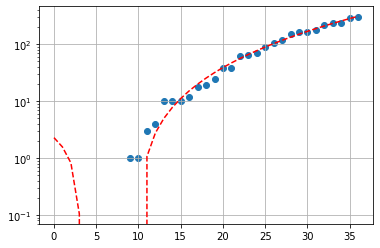

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.2159
Total cases up to today: 126
New cases registered today: 5
New cases registered today in %: 4.13
Doubling time in the last five days: 6.5
Doubling time yesterday: 4.5
Trend of new cases (in %) in the last 5 days: 70.27


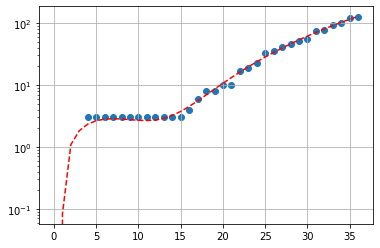

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 722
New cases registered today: 40
New cases registered today in %: 5.87
Doubling time in the last five days: 9.1
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 46.15


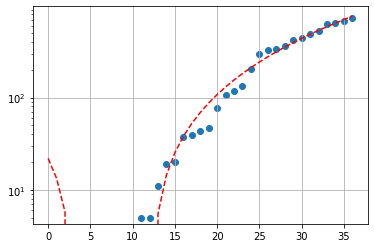

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.1981
Total cases up to today: 111
New cases registered today: 8
New cases registered today in %: 7.77
Doubling time in the last five days: 11.9
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 33.73


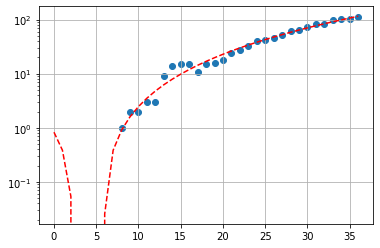

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.3652
Total cases up to today: 57
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 37.8
Doubling time yesterday: 4.4
Trend of new cases (in %) in the last 5 days: 9.62


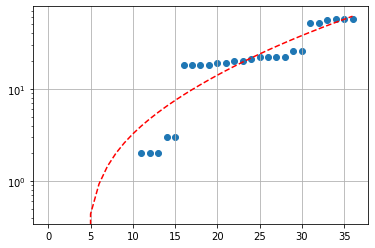

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.0622
Total cases up to today: 10
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 9.7
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 42.86


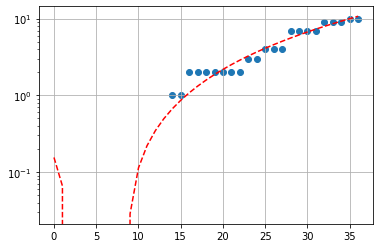

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.459
Total cases up to today: 486
New cases registered today: 32
New cases registered today in %: 7.05
Doubling time in the last five days: 9.0
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 46.83


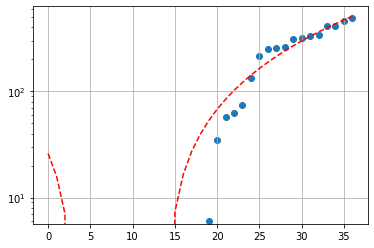

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1647
New cases registered today: 92
New cases registered today in %: 5.92
Doubling time in the last five days: 10.0
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 41.49


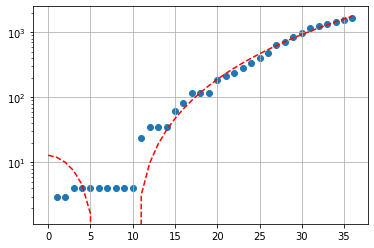

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2126
Total cases up to today: 94
New cases registered today: 5
New cases registered today in %: 5.62
Doubling time in the last five days: 6.5
Doubling time yesterday: 6.0
Trend of new cases (in %) in the last 5 days: 70.91


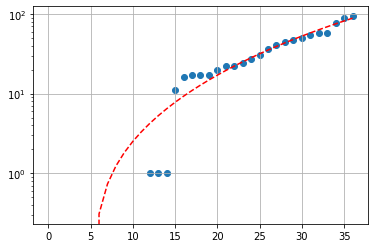

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.2595
Total cases up to today: 70
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 10.3
Doubling time yesterday: 7.8
Trend of new cases (in %) in the last 5 days: 40.0


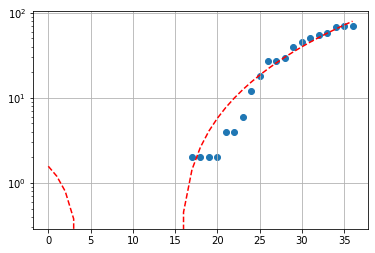

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.4473
Total cases up to today: 498
New cases registered today: 50
New cases registered today in %: 11.16
Doubling time in the last five days: 9.5
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 43.93


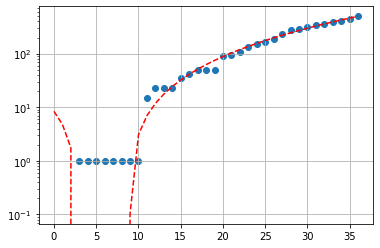

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.208
Total cases up to today: 203
New cases registered today: 8
New cases registered today in %: 4.1
Doubling time in the last five days: 8.2
Doubling time yesterday: 4.5
Trend of new cases (in %) in the last 5 days: 52.63


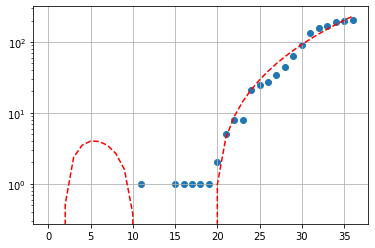

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.4885
Total cases up to today: 311
New cases registered today: 6
New cases registered today in %: 1.97
Doubling time in the last five days: 10.1
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 40.72


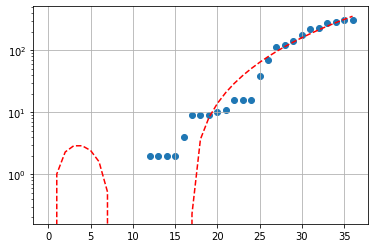

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.2066
Total cases up to today: 262
New cases registered today: 9
New cases registered today in %: 3.56
Doubling time in the last five days: 14.1
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 27.8


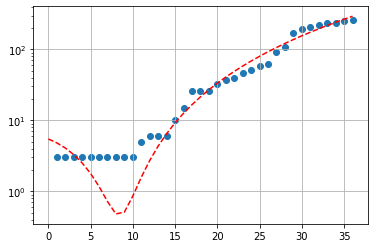

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.1338
Total cases up to today: 43
New cases registered today: 8
New cases registered today in %: 22.86
Doubling time in the last five days: 8.1
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 53.57


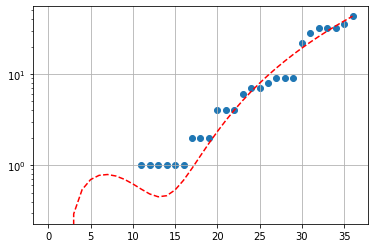

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.2309
Total cases up to today: 93
New cases registered today: 4
New cases registered today in %: 4.49
Doubling time in the last five days: 18.4
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 20.78


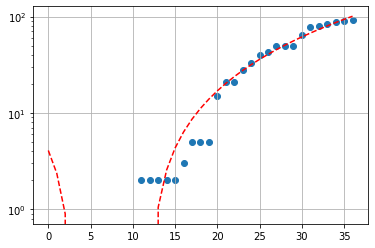

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.168
Total cases up to today: 73
New cases registered today: 2
New cases registered today in %: 2.82
Doubling time in the last five days: 8.7
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 48.98


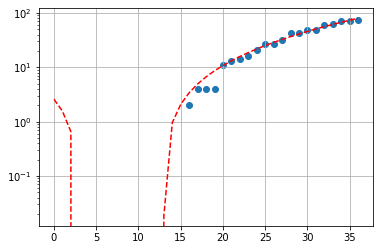

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 4608
New cases registered today: 196
New cases registered today in %: 4.44
Doubling time in the last five days: 9.7
Doubling time yesterday: 8.8
Trend of new cases (in %) in the last 5 days: 42.88


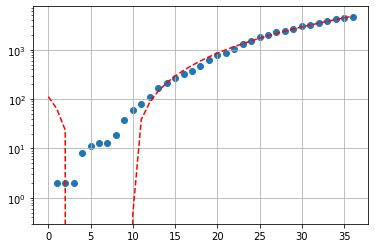

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 0.9641
Total cases up to today: 332
New cases registered today: 22
New cases registered today in %: 7.1
Doubling time in the last five days: 12.0
Doubling time yesterday: 11.4
Trend of new cases (in %) in the last 5 days: 33.33


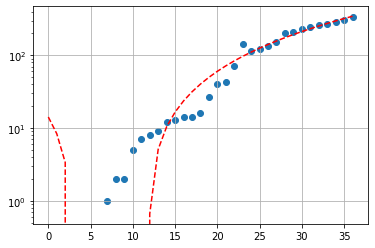

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 1.0715
Total cases up to today: 1087
New cases registered today: 65
New cases registered today in %: 6.36
Doubling time in the last five days: 9.8
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 42.28


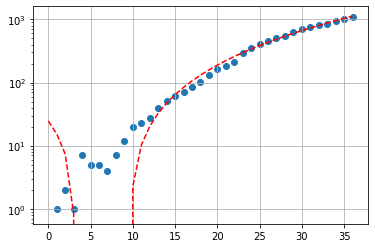

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.1522
Total cases up to today: 257
New cases registered today: 6
New cases registered today in %: 2.39
Doubling time in the last five days: 8.9
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 47.7


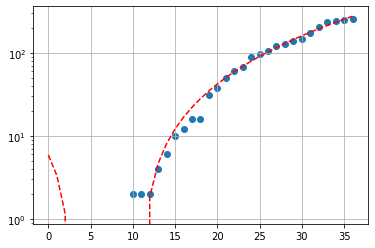

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.83
Total cases up to today: 280
New cases registered today: 9
New cases registered today in %: 3.32
Doubling time in the last five days: 10.9
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 37.25


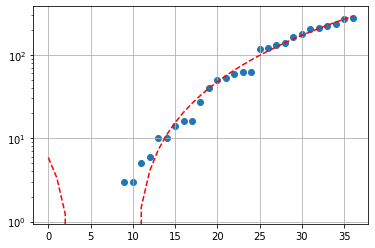

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 1.869
Total cases up to today: 729
New cases registered today: 18
New cases registered today in %: 2.53
Doubling time in the last five days: 8.3
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 51.56


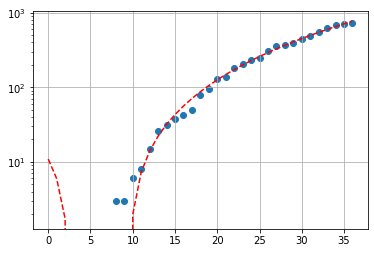

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 2.8538
Total cases up to today: 561
New cases registered today: 18
New cases registered today in %: 3.31
Doubling time in the last five days: 6.7
Doubling time yesterday: 7.0
Trend of new cases (in %) in the last 5 days: 67.96


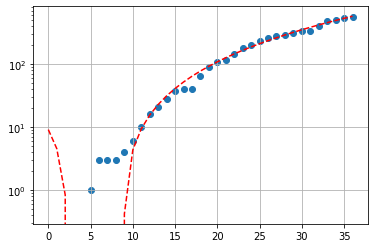

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.1165
Total cases up to today: 471
New cases registered today: 25
New cases registered today in %: 5.61
Doubling time in the last five days: 11.7
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 34.57


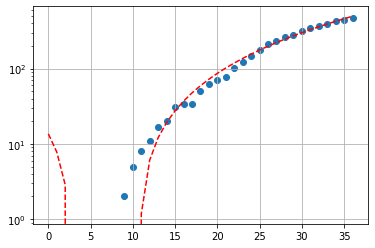

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.1376
Total cases up to today: 332
New cases registered today: 8
New cases registered today in %: 2.47
Doubling time in the last five days: 15.1
Doubling time yesterday: 14.2
Trend of new cases (in %) in the last 5 days: 25.76


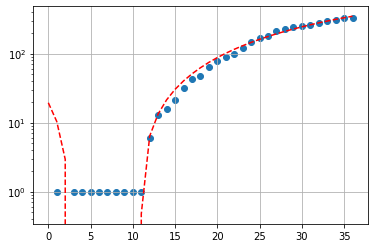

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.0133
Total cases up to today: 258
New cases registered today: 10
New cases registered today in %: 4.03
Doubling time in the last five days: 11.1
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 36.51


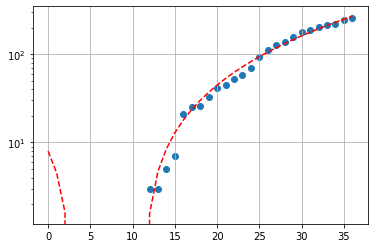

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.1217
Total cases up to today: 301
New cases registered today: 15
New cases registered today in %: 5.24
Doubling time in the last five days: 10.4
Doubling time yesterday: 8.8
Trend of new cases (in %) in the last 5 days: 39.35


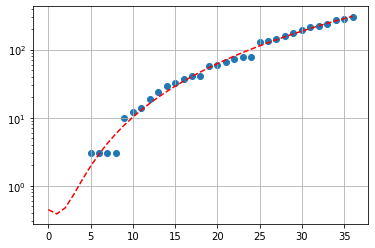

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 3.2417
Total cases up to today: 1746
New cases registered today: 64
New cases registered today in %: 3.8
Doubling time in the last five days: 11.7
Doubling time yesterday: 10.8
Trend of new cases (in %) in the last 5 days: 34.62


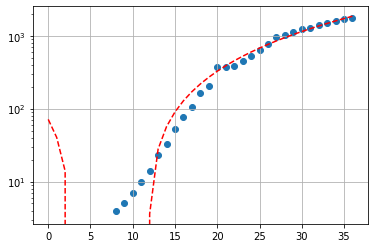

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1043
New cases registered today: 25
New cases registered today in %: 2.46
Doubling time in the last five days: 11.8
Doubling time yesterday: 8.8
Trend of new cases (in %) in the last 5 days: 34.06


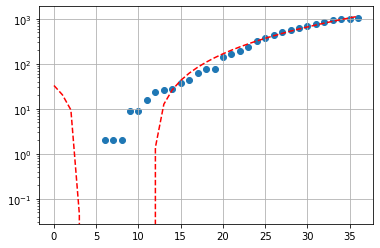

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.2305
Total cases up to today: 813
New cases registered today: 21
New cases registered today in %: 2.65
Doubling time in the last five days: 11.4
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 35.5


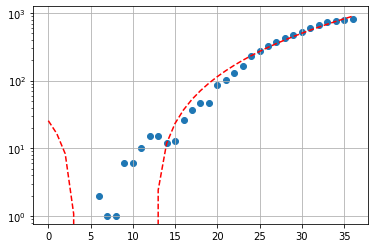

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.0078
Total cases up to today: 230
New cases registered today: 4
New cases registered today in %: 1.77
Doubling time in the last five days: 13.5
Doubling time yesterday: 10.6
Trend of new cases (in %) in the last 5 days: 29.21


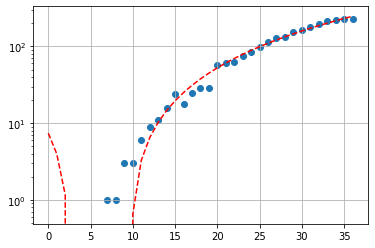

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 4.9494
Total cases up to today: 628
New cases registered today: 44
New cases registered today in %: 7.53
Doubling time in the last five days: 8.0
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 53.92


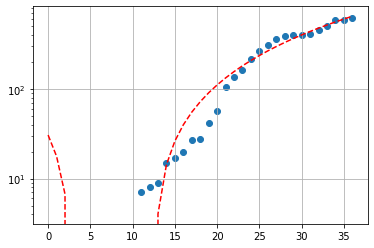

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 8876
New cases registered today: 428
New cases registered today in %: 5.07
Doubling time in the last five days: 12.2
Doubling time yesterday: 11.2
Trend of new cases (in %) in the last 5 days: 32.97


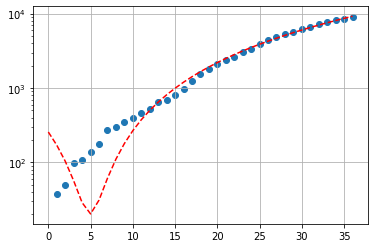

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 2.0896
Total cases up to today: 430
New cases registered today: 7
New cases registered today in %: 1.65
Doubling time in the last five days: 10.9
Doubling time yesterday: 9.9
Trend of new cases (in %) in the last 5 days: 37.38


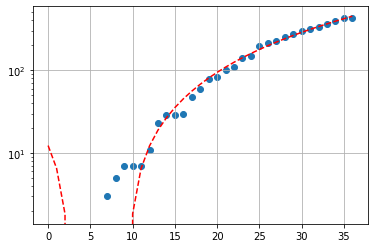

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.4181
Total cases up to today: 2264
New cases registered today: 76
New cases registered today in %: 3.47
Doubling time in the last five days: 14.3
Doubling time yesterday: 11.9
Trend of new cases (in %) in the last 5 days: 27.41


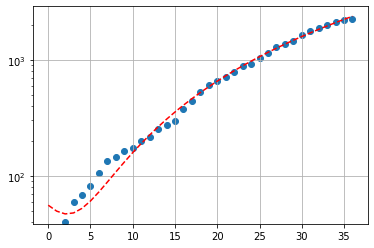

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.57
Total cases up to today: 136
New cases registered today: 5
New cases registered today in %: 3.82
Doubling time in the last five days: 16.3
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 23.64


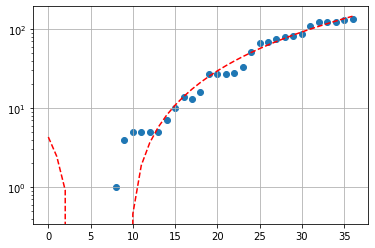

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.7179
Total cases up to today: 1522
New cases registered today: 73
New cases registered today in %: 5.04
Doubling time in the last five days: 17.9
Doubling time yesterday: 16.7
Trend of new cases (in %) in the last 5 days: 21.37


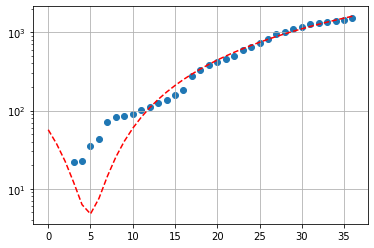

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.3696
Total cases up to today: 1170
New cases registered today: 63
New cases registered today in %: 5.69
Doubling time in the last five days: 14.4
Doubling time yesterday: 14.7
Trend of new cases (in %) in the last 5 days: 27.17


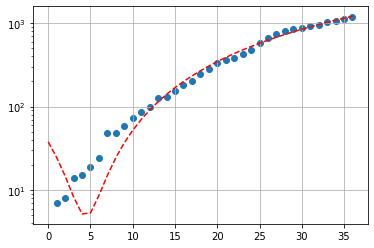

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 2.2918
Total cases up to today: 2112
New cases registered today: 130
New cases registered today in %: 6.56
Doubling time in the last five days: 8.5
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 50.64


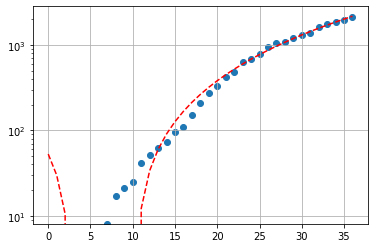

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.4357
Total cases up to today: 1242
New cases registered today: 74
New cases registered today in %: 6.34
Doubling time in the last five days: 10.7
Doubling time yesterday: 9.9
Trend of new cases (in %) in the last 5 days: 38.15


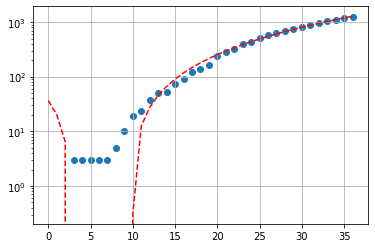

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')